In [2]:
# Setup and Imports

# Standard libraries to import
import os
import numpy as np
import random
from PIL import Image

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

# PyTorch the main library we will use to set up the neural networks and training
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision contains some utilities for working with images and datasets that are useful and make things easier
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using following device " + str(device))

# Function for setting the seed
# Seeds are important for reproducibility of the results
# In papers, you need to report average results over multiple runs with different seeds
# In this exercise, we will use a fixed seed to make the results reproducible

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42) # Set seed for reproducibility, 42 is a common choice, but you can use other numbers if you like

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Paths for data and models
DATASET_PATH = "../data"
CHECKPOINT_PATH = "saved_models"

print("Setup and imports complete.")


Using following device cpu
Setup and imports complete.


### Extended Explanation:

#### Imports:
1. **Standard Libraries:**
   - `os`: This library is used for interacting with the operating system, such as handling file paths.
   - `numpy` (`np`): A fundamental package for scientific computing with Python, providing support for arrays and mathematical functions.
   - `random`: This module implements pseudo-random number generators for various distributions.
   - `PIL` (Python Imaging Library): We use the `Image` class from PIL to handle image processing tasks.

2. **Plotting Libraries:**
   - `matplotlib.pyplot` (`plt`): A plotting library used for creating static, animated, and interactive visualizations in Python.
   - `matplotlib`: The main library that supports various backends and output formats. We set some default parameters for plotting, like line width.

3. **PyTorch Libraries:**
   - `torch`: The core library of PyTorch, providing support for tensor operations and dynamic computation graphs.
   - `torch.nn` (`nn`): A module that includes various neural network layers and functions.
   - `torch.utils.data` (`data`): This module provides utilities for data loading and preprocessing.
   - `torch.optim` (`optim`): Contains various optimization algorithms (e.g., SGD, Adam).
   - `DataLoader`: A utility class to load data in batches.

4. **Torchvision Libraries:**
   - `torchvision`: A package that includes popular datasets, model architectures, and image transformations.
   - `torchvision.datasets` (`CIFAR10`): Provides easy access to the CIFAR-10 dataset, a common benchmark dataset for image classification tasks.
   - `torchvision.transforms` (`transforms`): Offers various transformations (e.g., normalization, random cropping) for preprocessing and augmenting images.

#### Device Configuration:
- We set the device to GPU if available, else we use CPU. This ensures faster computation when a GPU is available.

#### Random Seed:
- We define and set a random seed using `random.seed`, `np.random.seed`, and `torch.manual_seed` to ensure reproducibility. This means that every time we run the script, we get the same results if the seed is fixed.

#### Paths:
- We specify the paths for datasets (`DATASET_PATH`) and model checkpoints (`CHECKPOINT_PATH`). This helps in organizing our data and saving the trained models for later use or evaluation.


100% 170M/170M [00:07<00:00, 23.7MB/s] 


Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]
Length train set:  45000
Length validation set:  5000
Length test set:  10000


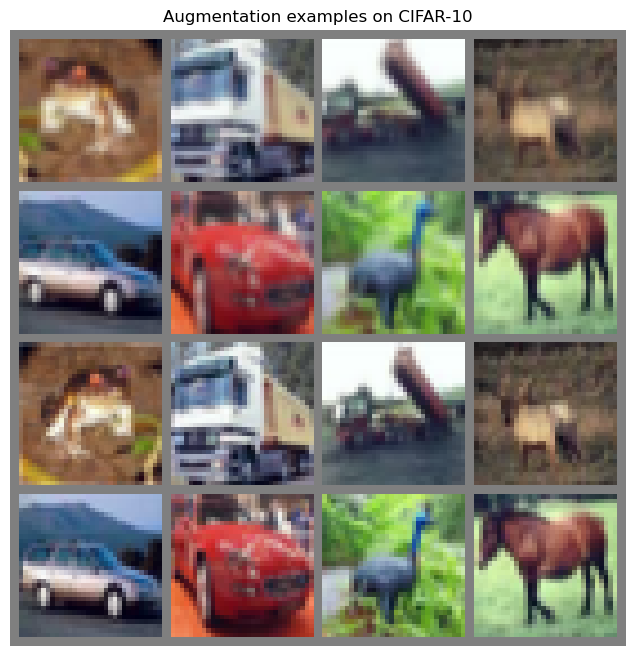

Data preparation and augmentation complete.


In [3]:
# Data Preparation and Augmentation

# Download the CIFAR-10 dataset and compute its mean and standard deviation
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

# Define transformations for training and testing datasets
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

# For training, we add augmentation to have more data points the network can train on. This often helps with overfitting or underfitting.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

# Load the training dataset with transformations
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

# Split the training dataset into training and validation sets
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Check if length for bot dataset splits is correct
print("Length train set: ", len(train_set))
print("Length validation set: ", len(val_set))

# This dataset is never seen by the model during training and functions as "unseen" data
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

print("Length test set: ", len(test_set))

# Define data loaders for training, validation, and testing
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

# Visualize some examples of data augmentation
NUM_IMAGES = 8
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR-10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

print("Data preparation and augmentation complete.")


### Extended Explanation:

#### Dataset Download:
1. **CIFAR-10 Download:** The CIFAR-10 dataset is a widely used benchmark dataset for image classification tasks. It consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. We download the training part of the dataset and compute its mean and standard deviation, which are later used for normalization.

#### Transformations:
2. **Data Normalization:** We normalize the images using the computed mean and standard deviation. Normalization is a common preprocessing step, because neural networks are much better in handling values between 0 to 1 or -1 to 1. It also speeds up the convergence process of the NN.
   - `transforms.ToTensor()`: Converts the images to PyTorch tensors and scales the values to [0.0, 1.0].
   - `transforms.Normalize(DATA_MEANS, DATA_STD)`: Normalizes the tensor images with the computed mean and standard deviation.

3. **Data Augmentation (Training Only):** Data augmentation techniques are applied to the training dataset to prevent overfitting and improve the model's generalization ability. The following transformations are used:
   - `transforms.RandomHorizontalFlip()`: Randomly flips the images horizontally with a probability of 0.5.
   - `transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1))`: Randomly crops the images to a size of 32x32 pixels, with the scale and aspect ratio specified.

#### Data Loaders:
4. **Creating Data Loaders:** Data loaders are essential for feeding the data into the model during training and evaluation in an efficient manner. They also help in handling batching, shuffling, and parallel data loading. Dataloader take datasets as an input. Usually the dataset split is 70% train data, 10% validation data and 20% test data, but it can vary.
   - `train_loader`: Loads the training data in batches, with shuffling and data augmentation.
   - `val_loader`: Loads the validation data without shuffling or augmentation.
   - `test_loader`: Loads the test data without shuffling or augmentation.

#### Visualization:
5. **Data Augmentation Visualization:** To provide a better understanding of the data augmentation techniques applied, we visualize some examples of the original and augmented images. This helps in understanding how the data augmentation transforms the training images to make the model robust.



# Convolutional Neural Networks

## Naive CNN

A naive CNN approach includes three basic building blocks:

1.   Convolution Filter
2.   Non-Linear Activations
3.   Pooling Layers

Your first task is to define all three blocks in the **NaiveCNNLayer**
class using the PyTorch implementations. If you are unsure what parameters are needed for specific classes look them up in the [documentation](https://docs.pytorch.org/docs/stable/nn.html). Look at different non-linear activation functions and choose one. Afterwards, you need to implement the forward function in the correct order.



In [ ]:
class NaiveCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_size=2):
        super(NaiveCNNLayer, self).__init__()

        # TODO fill in the three main building blocks
        # convolution uses 2D filters, as well as pooling

    def forward(self, x):

        # TODO apply all three building blocks on x in the correct order

        return x

The next code block defines the whole CNN using N-times the NaiveCNNBlock. The output of the code block displays the different layers of the naive CNN, together with an example of the output shapes when passing one datapoint through the model.

In [ ]:
class NaiveCNN(nn.Module):
    def __init__(self, num_blocks, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_size=2):
        super(NaiveCNN, self).__init__()

        # The nn.ModuleList() ensures that all NN blocks are added to the later backpropagation
        # The number of output channels are the next input channels and the output channels doubles in size per block
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(NaiveCNNLayer(in_channels, out_channels, kernel_size, stride, padding, pool_size))
            in_channels = out_channels
            out_channels *= 2

        # 2048 is fixed if we use the below defined number of blocks, in_channels and out_channels
        # If you want to change any of these parameters, you also need to adapt the input number for the nn.Linear() layer
        self.output_mlp = nn.Linear(2048, 10)

    def forward(self, x, debug=False):
        if debug:
          print("initial x shape: ", x.shape)

        for block in self.blocks:
            x = block(x)

            if debug:
              print("x shape after block: ", x.shape)

        x = torch.flatten(x, start_dim=1)

        if debug:
          print("x shape after flatten: ", x.shape)

        x = self.output_mlp(x)

        if debug:
          print("x shape after output mlp: ", x.shape)

        return x

naiveCNN = NaiveCNN(num_blocks=3, in_channels=3, out_channels=32).to(device)
print(naiveCNN)
for batch in train_loader:
    images, labels = batch
    out = naiveCNN(images.to(device), True)
    break

NaiveCNN(
  (blocks): ModuleList(
    (0): NaiveCNNLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): NaiveCNNLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): NaiveCNNLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (output_mlp): Linear(in_features=2048, out_features=10, bias=True)
)
initial x shape:  torch.Size([128, 3, 32, 32])
x shape after block:  torch.Size([128, 32, 16, 16])
x shape after block:  torch.Size([128, 64, 8, 8])
x shape after block:  torch.Size([128, 128, 4, 4])
x shape after flatten:  torch.S

### Extended Explanation

*   **First block** iterates over the given image and projects the 3 RGB channels to 32 while reducing the image size to 16x16
*   The **next two blocks** project the input down to 128x4x4
*   The **flatten method** concatenates all values together, except the ones from the first dimension (as this is our batch size)
*   The **last MLP** predicts the 10 classes from our 2048 vector

The shapes of our tensors consist of [B, C, W, H], where B represents batch size, C channel size, W width and H height.



## Improved CNN

An improved CNN layer restructures the arrangement of the main building blocks and adds specific improvements, like skip connections:

1.   Convolution Filter
2.   Non-Linear Activations
3.   Convolution Filter
4.   Non-Linear Activations
5.   Pooling Layers

This improved design gives the CNN a greater capacity to learn hierarchical, complex, and rich features from the data, as pooling layers are not learnable. Further, naivley stacking more and more blocks on each other can improve performance, but will break down if the model gets too deep. This performance decrease can be avoided by using skip connections introduced in ResNets. The second tasks includes implementing the improved CNN layer and introducing the skip connection principle in its forward function. More hints are given in the classes/functions.

In [ ]:
class ImprovedCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2, use_skip, kernel_size=3, stride=1, padding='same', pool_kernel_size=2, pool_stride=2):
        super(ImprovedCNNLayer, self).__init__()

        self.use_skip = use_skip

        # First Convolutional Layer
        self.conv1 = # TODO conv layer
        self.act1 = # TODO non-linear activation function

        # Second Convolutional Layer
        self.conv2 = # TODO conv layer (only the in and out channels change compared to conv1)
        self.act2 = # TODO non-linear activation function

        # Pooling Layer
        self.pool = # TODO pooling layer

        # check if we want to use skip connections
        if self.use_skip:
          # Skip Connection
          # We need a skip connection if the number of channels changes OR
          # if the stride of the first conv layer is not 1 (which changes spatial dimensions)
          self.skip_connection_needed = (in_channels != out_channels2) or (stride1 != 1)

          if self.skip_connection_needed:
              # This 1x1 conv will project the input 'x' to have the same number of channels
              # as the output of conv2 and also adjust spatial dimensions if stride1 > 1.
              # The stride in conv_skip should match stride1 to correctly downsample the skip connection.
              self.conv_skip = nn.Conv2d(in_channels, out_channels2, kernel_size=1, stride=stride1, bias=False)
          else:
              self.conv_skip = None # No projection needed
        else:
          self.conv_skip = None


    def forward(self, x):
        identity = # TODO Store the initial input for the skip connection

        # Main path
        out = # TODO apply first convolution layer
        out = # TODO apply first activation function
        out = # TODO apply second convolution layer

        # Skip connection
        if self.conv_skip is not None and self.use_skip:
            identity = self.conv_skip(identity)

        # Add skip connection
        if self.use_skip:
          out = # TODO apply skip connection
        out = # TODO apply final activation *after* adding the skip connection

        # Pooling
        output = # TODO apply pooling

        return output

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_layers, input_channels, num_classes, use_skip=True):
        super(ImprovedCNN, self).__init__()
        self.num_layers = num_layers
        self.use_skip = use_skip # Make use_skip a class attribute

        # Initial values (can be modified)
        initial_out_channels1 = 32
        initial_out_channels2 = 64

        # List to hold the ImprovedCNNLayer instances
        self.cnn_layers = nn.ModuleList()

        # Input layer
        self.cnn_layers.append(ImprovedCNNLayer(input_channels, initial_out_channels1, initial_out_channels2, use_skip=self.use_skip))

        # Dynamically calculate output channels for subsequent layers
        in_channels = initial_out_channels2  # First layer's out_channels2 becomes input for next
        for i in range(1, num_layers):
            # Double the number of filters, but set a maximum limit
            out_channels1 = min(in_channels * 2, 256)
            out_channels2 = min(out_channels1 * 2, 512)
            self.cnn_layers.append(ImprovedCNNLayer(in_channels, out_channels1, out_channels2, use_skip=self.use_skip))
            in_channels = out_channels2 # Update in_channels for the next layer

        # Fully connected layer for classification
        # The input features to the FC layer depend on the *last* CNN layer's output
        self.fc = nn.Linear(8192, num_classes) # in_channels from the *last* layer

    def forward(self, x):
        # Pass input through each ImprovedCNNLayer
        for layer in self.cnn_layers:
            x = layer(x)

        x = torch.flatten(x, 1)    # Flatten to: (batch_size, num_filters)

        # Fully connected layer
        x = self.fc(x)
        return x

improvedCNNnoSkip = ImprovedCNN(num_layers=3, input_channels=3, num_classes=10).to(device)
improvedCNNwithSkip = ImprovedCNN(num_layers=3, input_channels=3, num_classes=10, use_skip=True).to(device)
print(improvedCNNwithSkip)

ImprovedCNN(
  (cnn_layers): ModuleList(
    (0): ImprovedCNNLayer(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (act1): ReLU()
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (act2): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_skip): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ImprovedCNNLayer(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (act1): ReLU()
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (act2): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_skip): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ImprovedCNNLayer(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=s

## ResNet

There are only a few things missing to get from our **ImprovedCNN** to the traditional **[ResNet](https://arxiv.org/abs/1512.03385)**. The [PyTorch implementation](https://docs.pytorch.org/vision/main/models/resnet.html) includes batch normalization after each convolution block and has different building block orders. In the next code block, we will use the PyTorch version of ResNet18 for the dataset of CIFAR-10. This has two main advantages:

1.   You can be sure that the implementation does work as intended
2.   You can load already trained parameters and fine-tune the model on your new dataset

We will not use the pre-trained weights, but rather also train the network from scratch on the CIFAR-10 dataset.



In [ ]:
from torchvision.models import resnet18

class CIFAR10ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ResNet, self).__init__()
        self.model = resnet18(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


resnet = CIFAR10ResNet().to(device)
print(resnet)

CIFAR10ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# CIFARTrainer Class

class CIFARTrainer:
    def __init__(
        self,
        model,
        model_name,
        mode_stored_path,
        optimizer_name,
        optimizer_hparams
        ):
        """
        Inputs:
            model - The model that should be run.
            mode_stored_path - Path where the trained model will be saved.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD.
            optimizer_hparams - Hyperparameters for the optimizer, including learning rate, weight decay, etc.
        """
        self.model_stored_path = mode_stored_path
        os.makedirs(self.model_stored_path, exist_ok=True)
        # Create model
        self.model_name = model_name
        self.model = model
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Optimizer
        if optimizer_name == "Adam":
            self.optimizer = optim.AdamW(self.model.parameters(), lr=optimizer_hparams['lr'], weight_decay=optimizer_hparams['weight_decay'])
        elif optimizer_name == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=optimizer_hparams['lr'], momentum=optimizer_hparams['momentum'], weight_decay=optimizer_hparams['weight_decay'])
        else:
            raise ValueError(f"Unknown optimizer: '{optimizer_name}'")
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[100, 150], gamma=0.1)

        # Initialize best validation accuracy
        self.best_val_acc = 0.0
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            train_loss, train_acc = 0.0, 0.0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                preds = self.model(imgs)
                loss = self.loss_module(preds, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_acc += (preds.argmax(dim=-1) == labels).float().mean().item()

            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            self.train_losses.append(train_acc)

            val_acc = self.validate(val_loader)
            self.val_losses.append(val_acc)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            self.scheduler.step()

            # Save the model if the validation accuracy is the best we've seen so far
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                file_name = os.path.join(self.model_stored_path, f"{self.model_name}_best.pth")
                torch.save(self.model.state_dict(), file_name)
                print(f"Best model saved with validation accuracy: {val_acc:.4f}")

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Acc')
        plt.plot(self.val_losses, label='Val Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def validate(self, val_loader):
        self.model.eval()
        val_acc = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = self.model(imgs).argmax(dim=-1)
                val_acc += (labels == preds).float().mean().item()

        val_acc /= len(val_loader)
        return val_acc

    def test(self, test_loader):
        self.model.eval()
        test_acc = 0.0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = self.model(imgs).argmax(dim=-1)
                test_acc += (labels == preds).float().mean().item()

        test_acc /= len(test_loader)
        print(f"Test Accuracy: {test_acc:.4f}")
        return test_acc

print("CIFARTrainer class definition complete.")


CIFARTrainer class definition complete.


# CIFAR Trainer Class

We just introduced a simple Trainer class that will manage the training of our vision models for the Cifar10 dataset.


### Overview of Functionality

*  **Initialization:** The CIFARTrainer class initializes the model, loss function, optimizer, and learning rate scheduler. It also sets up paths for saving the best model.
*   **Training:** The train method handles the training loop, including forward and backward passes, and updates the model parameters. It also validates the model at the end of each epoch and saves the best model based on validation accuracy.
* **Validation:** The validate method evaluates the model on the validation set.
* **Testing:** The test method evaluates the model on the test set.
* **Plotting:** The plot_losses method plots the training and validation accuracy over epochs.


In [ ]:
# Training the Models

# Initialize and train the naive CNN
trainer_naive = CIFARTrainer(
    model=naiveCNN,
    model_name="naiveCNN",
    mode_stored_path=CHECKPOINT_PATH,
    optimizer_name='Adam',
    optimizer_hparams={'lr': 0.001, 'weight_decay': 1e-3}
)

# Training naive CNN
trainer_naive.train(train_loader, val_loader, num_epochs=10)
naive_val_results = trainer_naive.test(val_loader)
naive_test_results = trainer_naive.test(test_loader)
resnet_results = {"val": naive_val_results, "test": naive_test_results}

# Initialize and train improved CNN with no skip connection
trainer_improved_cnn_no_skip = CIFARTrainer(
    model=improvedCNNnoSkip,
    model_name="improvedCNNnoSkip",
    mode_stored_path=CHECKPOINT_PATH,
    optimizer_name='Adam',
    optimizer_hparams={'lr': 0.001, 'weight_decay': 1e-3}
)

# Training improved CNN with no skip connection
trainer_improved_cnn_no_skip.train(train_loader, val_loader, num_epochs=10)
improved_cnn_no_skip_val_results = trainer_improved_cnn_no_skip.test(val_loader)
improved_cnn_no_skip_test_results = trainer_improved_cnn_no_skip.test(test_loader)
improved_cnn_no_skip_results = {"val": improved_cnn_no_skip_val_results, "test": improved_cnn_no_skip_test_results}

# Initialize and train improved CNN with skip connection
trainer_improved_cnn_with_skip = CIFARTrainer(
    model=improvedCNNwithSkip,
    model_name="improvedCNNwithSkip",
    mode_stored_path=CHECKPOINT_PATH,
    optimizer_name='Adam',
    optimizer_hparams={'lr': 0.001, 'weight_decay': 1e-3}
)

# Training improved CNN with no skip connection
trainer_improved_cnn_with_skip.train(train_loader, val_loader, num_epochs=10)
improved_cnn_with_skip_val_results = trainer_improved_cnn_with_skip.test(val_loader)
improved_cnn_with_skip_test_results = trainer_improved_cnn_with_skip.test(test_loader)
improved_cnn_with_skip_results = {"val": improved_cnn_with_skip_val_results, "test": improved_cnn_with_skip_test_results}

# Initialize and train PyTorch ResNet
trainer_resnet = CIFARTrainer(
    model=resnet,
    model_name="ResNet",
    mode_stored_path=CHECKPOINT_PATH,
    optimizer_name='Adam',
    optimizer_hparams={'lr': 0.001, 'weight_decay': 1e-3}
)

# Training PyTorch ResNet
trainer_resnet.train(train_loader, val_loader, num_epochs=10)
resnet_val_results = trainer_resnet.test(val_loader)
resnet_test_results = trainer_resnet.test(test_loader)
resnet_results = {"val": resnet_val_results, "test": resnet_test_results}

print("Training and evaluation complete.")

Epoch 1/10, Train Loss: 1.4878, Train Acc: 0.4667, Val Acc: 0.5480
Best model saved with validation accuracy: 0.5480
Epoch 2/10, Train Loss: 1.1187, Train Acc: 0.6097, Val Acc: 0.6393
Best model saved with validation accuracy: 0.6393
Epoch 3/10, Train Loss: 0.9752, Train Acc: 0.6625, Val Acc: 0.6828
Best model saved with validation accuracy: 0.6828
Epoch 4/10, Train Loss: 0.8817, Train Acc: 0.6972, Val Acc: 0.6984
Best model saved with validation accuracy: 0.6984
Epoch 5/10, Train Loss: 0.8234, Train Acc: 0.7165, Val Acc: 0.7129
Best model saved with validation accuracy: 0.7129
Epoch 6/10, Train Loss: 0.7776, Train Acc: 0.7314, Val Acc: 0.7391
Best model saved with validation accuracy: 0.7391
Epoch 7/10, Train Loss: 0.7337, Train Acc: 0.7463, Val Acc: 0.7391
Epoch 8/10, Train Loss: 0.7091, Train Acc: 0.7558, Val Acc: 0.7592
Best model saved with validation accuracy: 0.7592
Epoch 9/10, Train Loss: 0.6798, Train Acc: 0.7655, Val Acc: 0.7635
Best model saved with validation accuracy: 0.76

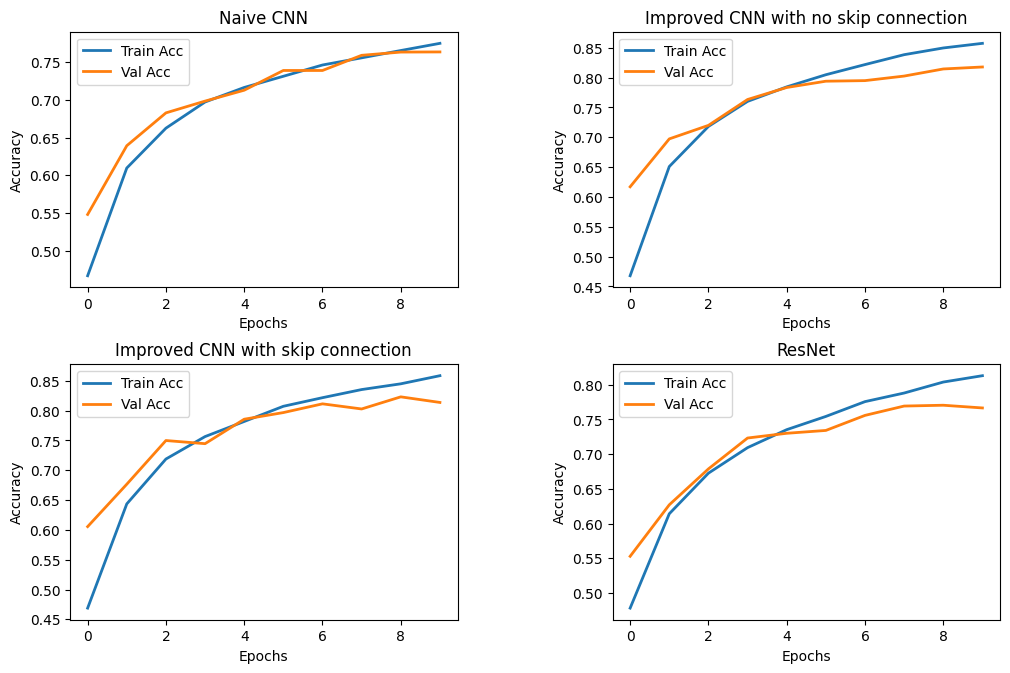

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

# Naive CNN
plt.subplot(2, 2, 1)
plt.plot(trainer_naive.train_losses, label='Train Acc')
plt.plot(trainer_naive.val_losses, label='Val Acc')
plt.title('Naive CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Improved CNN with no skip
plt.subplot(2, 2, 2)
plt.plot(trainer_improved_cnn_no_skip.train_losses, label='Train Acc')
plt.plot(trainer_improved_cnn_no_skip.val_losses, label='Val Acc')
plt.title('Improved CNN with no skip connection')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Improved CNN with skip
plt.subplot(2, 2, 3)
plt.plot(trainer_improved_cnn_with_skip.train_losses, label='Train Acc')
plt.plot(trainer_improved_cnn_with_skip.val_losses, label='Val Acc')
plt.title('Improved CNN with skip connection')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# ResNet
plt.subplot(2, 2, 4)
plt.plot(trainer_resnet.train_losses, label='Train Acc')
plt.plot(trainer_resnet.val_losses, label='Val Acc')
plt.title('ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)

plt.show()

What conclusions and insights can you draw from the training curves?